In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import zipfile
import sklearn
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [3]:
z = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv(z.open('train.csv'))

## Target Exploration

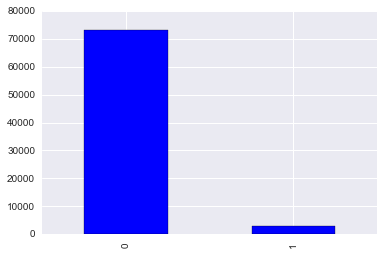

In [4]:
df.TARGET.value_counts().plot(kind='bar')

In [5]:
num_positive = len(df[df['TARGET'] == 1])
num_negative = len(df) - num_positive
print num_positive / float(num_negative)

0.0411987070619


## Reverse Feature Engineering

In [28]:
def drop_constants(df):
    constant_features = []
    for col in df.columns:
        if df[col].std() == 0:
            constant_features.append(col)
    ndf = df.drop(constant_features, axis=1)
    print len(constant_features), 'features dropped because they are constant.'
    return (constant_features, ndf)

In [30]:
def drop_lin_coms(df):
    with open('rfe_from_forum.txt', 'r') as f:
        lines = f.readlines()
        lines = [line.strip().split(' ')[0] for line in lines]
    lin_com_features = lines
    ndf = df.drop(lin_com_features, axis=1)
    print len(lin_com_features), 'features dropped because they are linear combinations.'
    return (lin_com_features, ndf)

In [35]:
def drop_high_corrs(df):
    high_corr_features = []
    safe = []
    for x in df.columns.values:
        for y in safe:
            if (abs(np.corrcoef(df[y], df[x])[0,1]) > 0.999):
                high_corr_features.append(x)
                break
        safe.append(x)
    ndf = df.drop(high_corr_features, axis=1)
    print len(high_corr_features), 'features dropped because they are in linear relation with other features.'
    return (high_corr_features, ndf)

In [36]:
df = pd.read_csv(z.open('train.csv'))
constant_features, ndf = drop_constants(df)
lin_com_features, ndf = drop_lin_coms(ndf)
high_corr_features, ndf = drop_high_corrs(ndf)

34 features dropped because they are constant.
40 features dropped because they are linear combinations.
56 features dropped because they are in linear relation with other features.


In [40]:
dropped_features = constant_features + lin_com_features + high_corr_features
with open('dropped_features.txt', 'w') as f:
    f.writelines([s+'\n' for s in dropped_features])
import cPickle as pickle
with open('dropped_features.dump', 'w') as f:
    pickle.dump(dropped_features, f)

## Downsampling Majority Class

In [6]:
# not necessary if we use boosting

In [93]:
df_positive = df[df['TARGET'] == 1]
df_negative = df[df['TARGET'] == 0].sample(frac=num_positive / float(num_negative))

In [94]:
ndf = pd.concat([df_positive, df_negative])

## Feature Importance

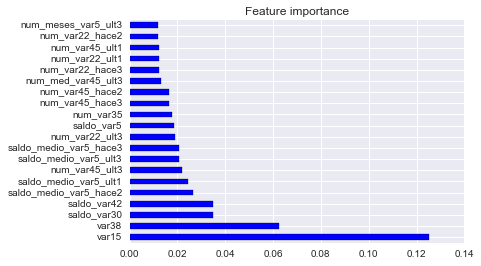

In [7]:
x = df.drop(['ID', 'TARGET'], axis=1)
y = df['TARGET']
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=16, oob_score=True)
rfc.fit(x, y)
feat_imp = pd.Series(rfc.feature_importances_, index=x.columns)
feat_imp.sort_values(inplace=True, ascending=False)
feat_imp.head(20).plot(kind='barh', title='Feature importance')

In [99]:
cv = cross_validation.StratifiedKFold(y, n_folds=4, shuffle=True)
scores = cross_validation.cross_val_score(rfc, x, y, cv=cv, scoring='roc_auc')
print("Auc: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
rfc.fit(x, y)

Auc: 0.829 (+/- 0.013)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

## Starter Submission

In [37]:
import datetime

In [50]:
def export_predictions(model, method, num=1):
    test = pandas.read_csv(zipfile.ZipFile('test.csv.zip').open('test.csv'))
    id_test = test['ID']
    x_test = test.drop(['ID'], axis=1)
    y_pred = model.predict_proba(x_test)
    sub = pandas.DataFrame({'ID': id_test, 'TARGET': y_pred[:,1]})
    filename = 'submission_{date}#{num}_{method}.csv'.format(date=datetime.date.today().isoformat(), num=num, method=method)
    sub.to_csv(filename, index=False)

In [90]:
export_predictions(rfc, 'rfc-undersampling-tuned', 4)

## Further Visualization

In [8]:
def filter_feature_by_importance_percentage(imp, per):
    assert per <= 1.0 and per >= 0
    imp_sorted = imp.sort_values(ascending=False)
    total_per = 0
    for (i, v) in enumerate(imp_sorted):
            total_per += v
            if total_per >= per:
                return imp[:i+1]
    return imp

In [9]:
print len(feat_imp)
filtered_feat_imp = filter_feature_by_importance_percentage(feat_imp, 0.95)
filtered_feat_imp_list = list(filtered_feat_imp.index.values)
print len(filtered_feat_imp)

369
110


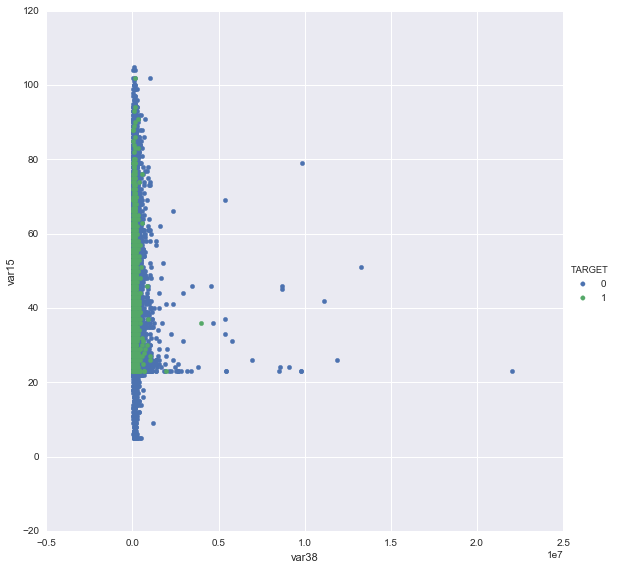

In [10]:
sns.FacetGrid(df, hue="TARGET", size=8).map(plt.scatter, "var38", "var15").add_legend()

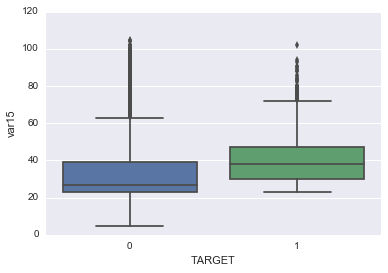

In [12]:
sns.boxplot(x='TARGET', y='var15', data=df)

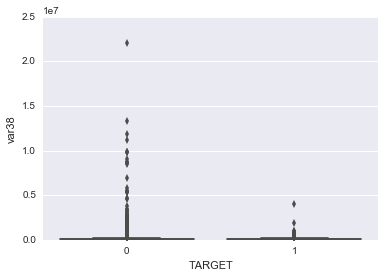

In [13]:
# How to scale this?
sns.boxplot(x='TARGET', y='var38', data=df)

In [15]:
def top_k_feature_pairwise_plot(df, imp, target):
    df = df[imp + [target]]
    sns.pairplot(data = df, hue=target, vars=imp, size=10)

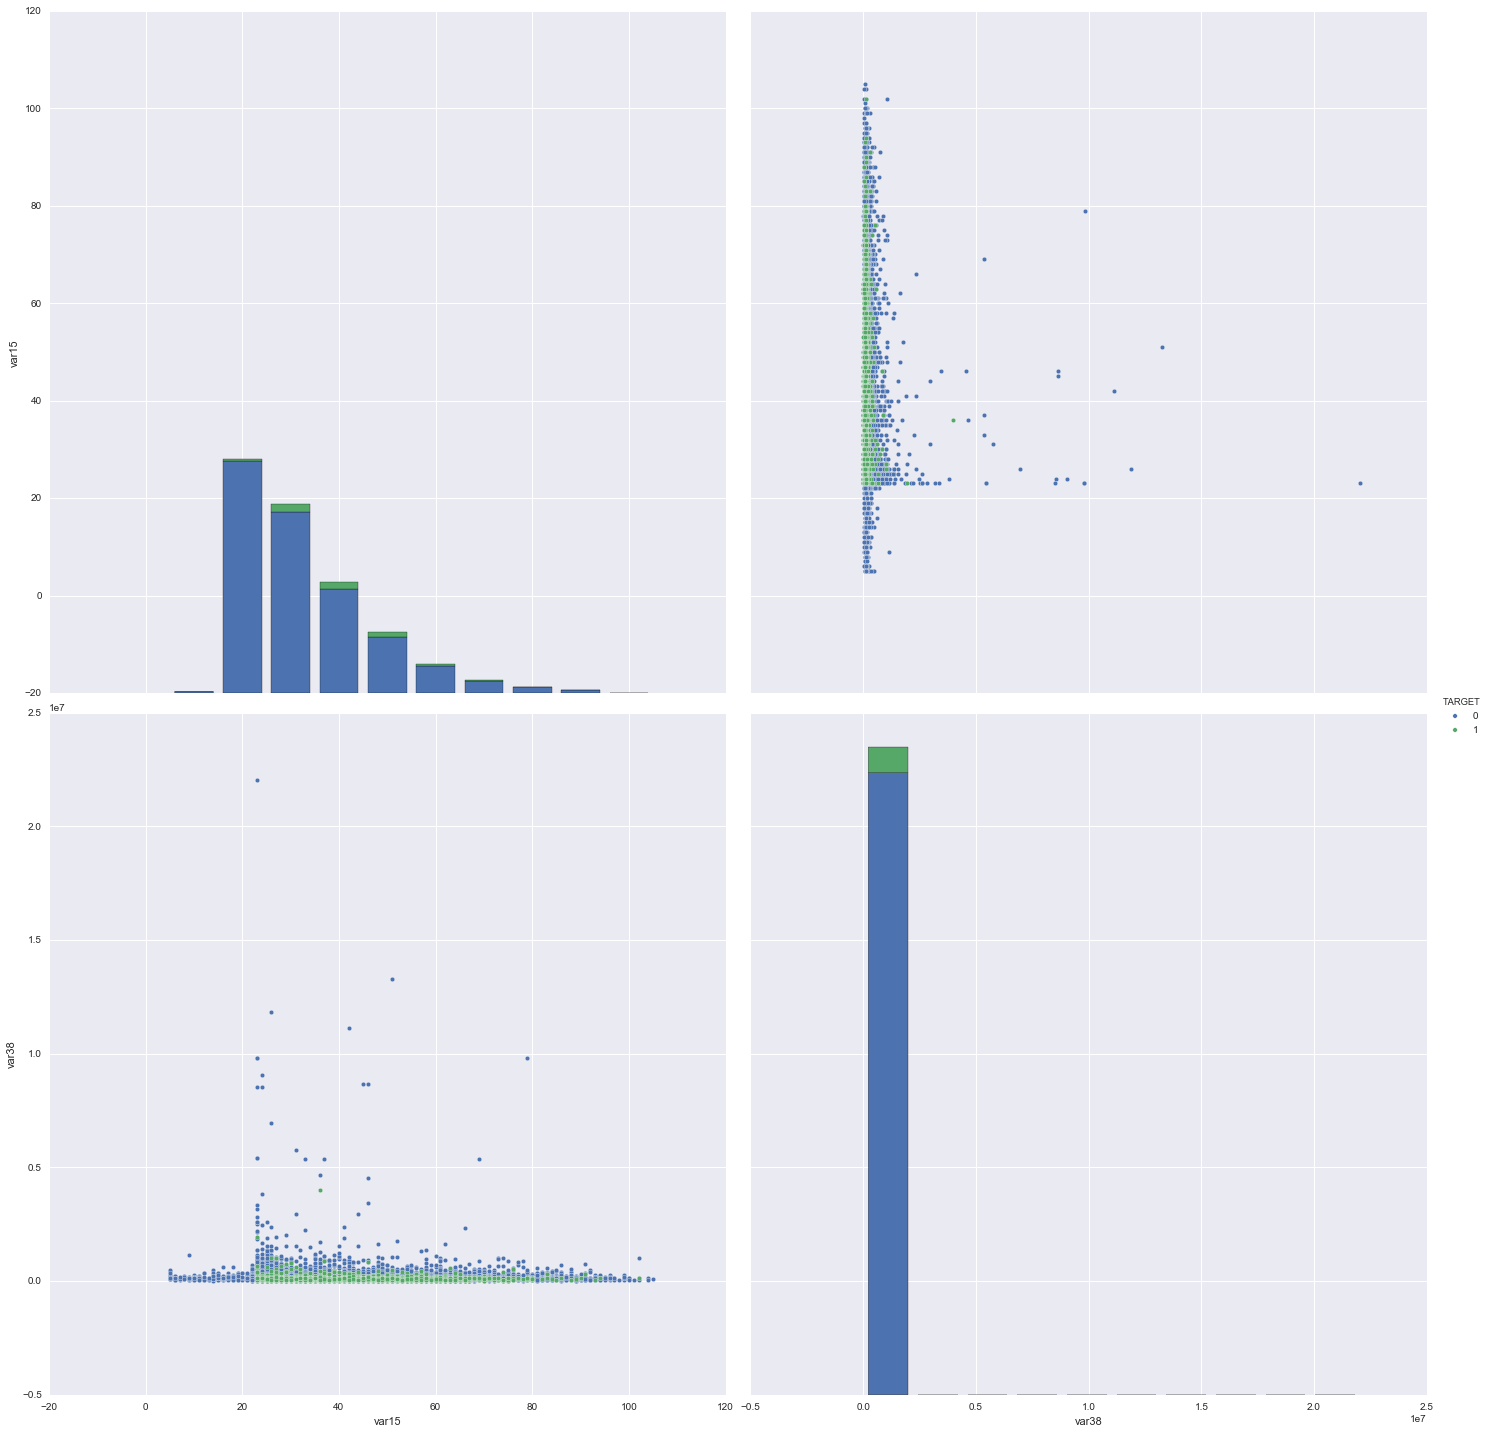

In [16]:
top_k_feature_pairwise_plot(df, filtered_feat_imp_list[:2], 'TARGET')